## Anomaly detection with PCA
In this note, I demonstrate anomaly detection with credit card fraud dataset. I also investigate how the compression of dataset through PCA affect the quality of anomaly detection systems.

### Review: Anomaly detection
Anomaly detection is the technique to detect unusual data, called anomalies or outliers, based on some distance from the majority of data which described as normal. Although the data may have labels showing if this data is normal or not, anomaly detection is a kind of unsupervised learning since only the data identifed as normal are used. While the goal of anomaly detection is same as that of supervised learning algorithms for binary classification problems, it is often more useful when the dataset is skewed so that the number of anomalies are far less than the number of normal data.

### Mahalanobis distance
When the data has only single feature, one can quantify how far a data is located from the entire dataset by measuring its difference from the mean in the unit of the standard deviation. For multivariate dataset, I can still do the same. In this case, however, measuring the differences along each feature might not be the best way since different features might be correlated. Therefore, I need to find linear combinations of these features where different combinations are not correlated before measurement.

The Mahalanobis distance is the measure made with exactly that consideration. Formaliy speaking, for a dataset of $p$ features, $X_1,\cdots,X_p$, the Mahalanobis distance for a data point $\mathbf{x}=(x_1,\cdots,x_p)^T$ is defined as
$$\begin{eqnarray}
D(\mathbf{x}) = \sqrt{(\mathbf{x}-\mathbf{\mu})^T S^{-1} (\mathbf{x}-\mathbf{\mu})},
\end{eqnarray}$$
where $\mathbf{\mu}=(\mu_1,\cdots,\mu_p)^T=(\text{E}[X_1],\cdots,\text{E}[X_p])^T$ is the mean vector and $S$ is the covariance matrix,
$$\begin{eqnarray}
S=\left(\begin{array}{ccc}
\text{E}[(X_1-\mu_1)(X_1-\mu_1)] & \cdots & \text{E}[(X_1-\mu_1)(X_p-\mu_p)] \\
\vdots & \ddots & \vdots \\
\text{E}[(X_p-\mu_p)(X_1-\mu_1)] & \cdots & \text{E}[(X_p-\mu_p)(X_p-\mu_p)]
\end{array}\right).
\end{eqnarray}$$

To illustrate the intuition behind this definition, now I consider a scenario where there are only two uncorrelated features, $X_1$ and $X_2$. Since $\text{E}[(X_1-\mu_1)(X_2-\mu_2)]=0$, the covariance matrix is simply $S=\text{diag}(\sigma_1^2,\sigma_2^2)$, and therefore $S^{-1}=\text{diag}(\sigma_1^{-2},\sigma_2^{-2})$. With this, Mahalanobis distance is simply $D(\mathbf{x})=\left(\frac{x_1-\mu_1}{\sigma_1}\right)^2 + \left(\frac{x_2-\mu_2}{\sigma_2}\right)^2$, which is nothing but the Euclidean distance in the centered and normalized coordinates of $x_1$ and $x_2$ from the origin.

This intuition can be extended for correlated variables $X_1,\cdots,X_p$ since one can find a rotation to uncorrelated variables $Y_1,\cdots,Y_p$ while preserving the distances. This rotation matrix can be found the diagonalization procedure of the covariance matrix or the singular value decomposition (SVD) of the design matrix. If this rotation matrix and variances are obtained, one may calculate Mahalanobis distance for arbitrary data point and therefore can identify anomalies based on some threshold distance.

### Demonstration with credit card fraud dataset
Now I demonstrate anomaly detection with credit card fraud dataset found in https://github.com/GuansongPang/anomaly-detection-datasets, which is taken from https://www.kaggle.com/mlg-ulb/creditcardfraud.

I first load relevant libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA

Then I load the dataset, and divide it by the classes. 'class'=0 indicates normal data while 'class'=1 indicate fraudulent cases, which are our anomalies. To explore the dataset, I present the summary of the normal data which would be used for the learning.

In [2]:
df=pd.read_csv("fraud_normalized.csv")
#df.head()
df_normal=df[df["class"]==0]
df_anomaly=df[df["class"]==1]
df_normal=df_normal.drop(columns=["class"])
df_anomaly=df_anomaly.drop(columns=["class"])
print("Number of anomalies:",len(df_anomaly))
print("Summary of normal data:")
df_normal.describe()

Number of anomalies: 492
Summary of normal data:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000
mean,0.958434,0.767192,0.837625,0.251582,0.765753,0.263044,0.265414,0.785375,0.462934,0.508925,...,0.580258,0.561460,0.510030,0.665435,0.382259,0.577903,0.425434,0.416506,0.313121,0.003437
std,0.032785,0.017264,0.025290,0.062031,0.009135,0.013371,0.007181,0.012457,0.037527,0.021604,...,0.008192,0.011554,0.033759,0.009230,0.081628,0.029227,0.078773,0.007380,0.006688,0.009735
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071840,0.000000,0.246075,0.203734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.942706,0.760933,0.822086,0.214247,0.761075,0.255310,0.261996,0.783147,0.440719,0.497697,...,0.578011,0.557796,0.484728,0.663032,0.334476,0.560105,0.372022,0.415203,0.312049,0.000220
50%,0.958634,0.767934,0.840570,0.250937,0.765356,0.260274,0.265606,0.785622,0.461059,0.506821,...,0.579598,0.560999,0.510345,0.665268,0.387770,0.578828,0.416917,0.416534,0.313351,0.000856
75%,0.980655,0.775704,0.855234,0.284629,0.769837,0.267038,0.268834,0.788885,0.483388,0.518139,...,0.581675,0.564472,0.534681,0.667624,0.441506,0.597586,0.464761,0.418183,0.314706,0.002999
max,1.000000,0.966707,1.000000,1.000000,1.000000,1.000000,1.000000,0.986077,1.000000,1.000000,...,1.000000,0.926040,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the normal dataset, I calculate the covariance matrix through the sklearn library. The covariance object in this library provides a function to calculate the Mahalanobis distances. With this function, I calculate the Mahalanobis distance for the normal dataset and the anomaly dataset. The histogram plots of these distances show that anomaly data are located at far larger Mahalanobis distances.

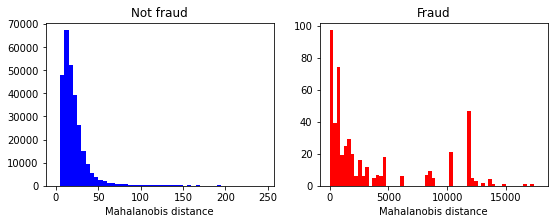

In [3]:
cov=EmpiricalCovariance().fit(df_normal)
dist_normal=cov.mahalanobis(df_normal)
dist_anomaly=cov.mahalanobis(df_anomaly)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(dist_normal,bins=np.arange(0,250,5),color="b")
plt.title("Not fraud")
plt.xlabel("Mahalanobis distance")
plt.subplot(1,2,2)
plt.hist(dist_anomaly,bins=np.arange(0,18000,300),color="r")
plt.title("Fraud")
plt.xlabel("Mahalanobis distance");

### Precision, recall, and F1 score

While the threshold for the Mahalanobis distance for anomaly detection can be set arbitrarily, we may vary the threshold to find the optimal value that gives the best performance.

While the accuracy of cross validation set is typical benchmark for the supervised learning classification problems, other metrics are often used for the skewed dataset. To begin with, notice that there exist 4 categories for each data in the entire dataset.
* True Positive (TP): Diagonsed as anomaly, the data is indeed anomaly
* True Negative (TN): Diagonsed as normal, the data is indeed normal
* False Positive (FP): Diagnosed as anomaly, but the data is normal
* False Negative (FN): Diagnosed as normal, but the data is anomaly

With the number of data belonging to each category, there are two basic metrics to measure the performance of anomaly detection:
* Precision: Ratio of the true postives over all the cases diagonsed as anomaly
$=\text{TP}/(\text{TP}+\text{FP})$
* Recall: Ratio of the true postives over all the anomalies
$=\text{TP}/(\text{TP}+\text{FN})$

Precision is often regarded important when the cost of false postive is high. For example, diagnosis tests for serious diseases need high precision to minimize the inconvenience of patients who falsely diagonsed postive. On the other hand, recall becomes an important metric when it is important to detect every anomaly. Detection for suspicious activities in a website or suspicious financial transactions can be regarded as such tasks.

Or, one may use the combination of both. F1 score is such metric. F1 score is the harmonic mean of precision and recall:
* $F_1 = 2*\text{Precision}*\text{Recall}/(\text{Precision}+\text{Recall})
= \text{TP}/[\text{TP}+(\text{FP}+\text{FN})/2]$

For the Mahalanobis distances calculated above, I calculate precision, recall, and F1 score for different choices of threshold distances. For the current dataset, it seems the threshold around 1000 gives the best F1 score. Or, one may wish to stick with lower threshold to increase the recall since this anomaly detection task aims to find the suspicious data as much as possible.

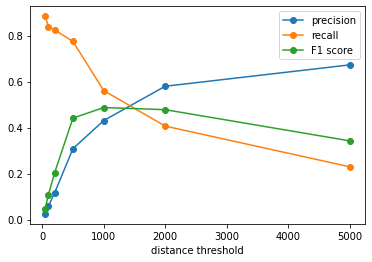

In [4]:
dists=[50,100,200,500,1000,2000,5000]
precisions=[]
recalls=[]
F1s=[]
for dist_thre in dists:
    TN=sum((dist_normal<dist_thre)*1)
    FN=sum((dist_anomaly<dist_thre)*1)
    FP=sum((dist_normal>=dist_thre)*1)
    TP=sum((dist_anomaly>=dist_thre)*1)

    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1=2*(precision*recall)/(precision+recall)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(F1)
plt.figure()
plt.plot(dists,precisions,"-o")
plt.plot(dists,recalls,"-o")
plt.plot(dists,F1s,"-o")
plt.xlabel("distance threshold")
plt.legend(["precision","recall","F1 score"]);

### Principal component analysis (PCA)

While calculation of covariance matrix is managable when the number of features are relatively small, it can be computationally expensive if there are a huge number of features to consider. In such cases, it is important to compress the dataset so that it only remains relevant features. This also requires that the remained features need to be uncorrelated each other so that they can cover the variance of the original dataset as much as they can.

Principal component analysis (PCA) can do such operation. Mathematically, PCA is nothing but the diagonalization of the covariance matrix, which I briefly mentioned in the paragrph for the Mahalonobis distance. Now this diagonalization can be written as
$$\begin{eqnarray}
S = M^{-1} D M \quad\text{where}\quad D=\text{diag}({\sigma'}_1^2,\cdots,{\sigma'}_p^2).
\end{eqnarray}$$
Now by changing the orders of rows in $M$, we can choose the orders between ${\sigma'}_i^2$ freely. Suppose we order in non-increasing manner, ${\sigma'}_1^2 \ge {\sigma'}_2^2 \ge \cdots \ge {\sigma'}_p^2$. Now if ${\sigma'}_i^2$ is much less than $\sum_{j=1}^p {\sigma'}_j^2$ for $i>n$, we can approximate $S$ by setting ${\sigma'}_i=0$ for $i>n$ and only keep $n$ diagonal elements. By doing so, one does not need to diagonalize entire $S$ and can truncate the calculation after obtaining $n$ variances and corresponding eigenvectors. With iterative algorithms like Lanczos algorithm, one can save a lot of computation resources when $n\ll p$.

Truncation in PCA not only makes the calculation efficient, but also can help make dataset more intelligible by reducing the dimension. For example, if one only keeps the dimensions up to 3, one can visulaize its scatter plot while it is impossible for dataset with higher dimension.

Now for the credit card fraud dataset, I apply PCA first and remain only 10 dimensions, then calculate the Mahalanobis distances. Compared to the previous calculation using all the dimensions, the difference between the normal dataset and the anomaly dataset becomes smaller. One may also note that overall scale of the distances got smaller after the dimension reduction.

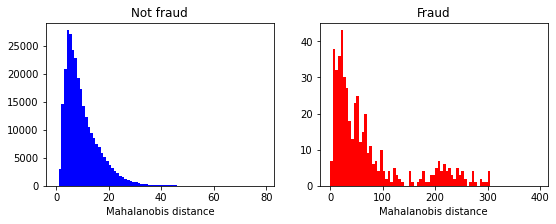

In [5]:
n_comp=10
pca=PCA(n_components=n_comp)
pca.fit(df_normal)

df_proj_normal=pd.DataFrame()
df_proj_anomaly=pd.DataFrame()
for i in range(n_comp):
    df_proj_normal["dim"+str(i+1)]=((pca.components_[i])*df_normal).sum(axis=1)
    df_proj_anomaly["dim"+str(i+1)]=((pca.components_[i])*df_anomaly).sum(axis=1)

cov_pca=EmpiricalCovariance().fit(df_proj_normal)
dist_normal=cov_pca.mahalanobis(df_proj_normal)
dist_anomaly=cov_pca.mahalanobis(df_proj_anomaly)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(dist_normal,bins=np.arange(0,80),color="b")
plt.title("Not fraud")
plt.xlabel("Mahalanobis distance")
plt.subplot(1,2,2)
plt.hist(dist_anomaly,bins=np.arange(0,400,5),color="r")
plt.title("Fraud")
plt.xlabel("Mahalanobis distance");

As in the calculation with all features, I calculate the precision, recall, and F1 score for different distance thresholds. While F1 score is optimized around the distance of 50, the overall F1 score decreased when comparing with the calculation with all features.

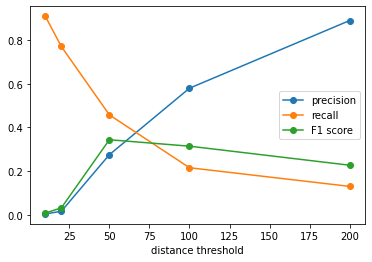

In [6]:
dists=[10,20,50,100,200]
precisions=[]
recalls=[]
F1s=[]
for dist_thre in dists:
    TN=sum((dist_normal<dist_thre)*1)
    FN=sum((dist_anomaly<dist_thre)*1)
    FP=sum((dist_normal>=dist_thre)*1)
    TP=sum((dist_anomaly>=dist_thre)*1)

    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1=2*(precision*recall)/(precision+recall)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(F1)
plt.figure()
plt.plot(dists,precisions,"-o")
plt.plot(dists,recalls,"-o")
plt.plot(dists,F1s,"-o")
plt.xlabel("distance threshold")
plt.legend(["precision","recall","F1 score"]);

I finally check how much of the variance is preserved in the reduced dataset compared to the original dataset. In this 10-dimensional reduction, I am preserving roughly 85% of the original varainces.

In [7]:
print("PCA explained variance ratio:",sum(pca.explained_variance_ratio_))

PCA explained variance ratio: 0.8469641388144306


I try further dimension reduction and repeat the same calculation. In this reduction to the 2-dimensional data, the difference of the normal data and the anomaly data is not obvious when looking at the Mahalanobis distance.

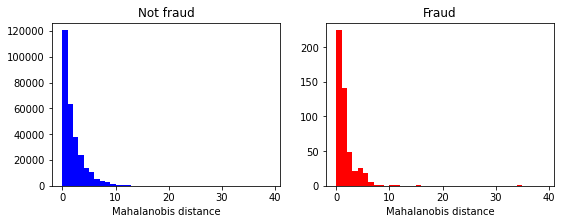

In [8]:
pca=PCA(n_components=2)
pca.fit(df_normal)

df_proj_normal=pd.DataFrame()
df_proj_normal["dim1"]=((pca.components_[0])*df_normal).sum(axis=1)
df_proj_normal["dim2"]=((pca.components_[1])*df_normal).sum(axis=1)
df_proj_anomaly=pd.DataFrame()
df_proj_anomaly["dim1"]=((pca.components_[0])*df_anomaly).sum(axis=1)
df_proj_anomaly["dim2"]=((pca.components_[1])*df_anomaly).sum(axis=1)

cov_pca=EmpiricalCovariance().fit(df_proj_normal)
dist_normal=cov_pca.mahalanobis(df_proj_normal)
dist_anomaly=cov_pca.mahalanobis(df_proj_anomaly)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(dist_normal,bins=np.arange(0,40),color="b")
plt.title("Not fraud")
plt.xlabel("Mahalanobis distance")
plt.subplot(1,2,2)
plt.hist(dist_anomaly,bins=np.arange(0,40),color="r")
plt.title("Fraud")
plt.xlabel("Mahalanobis distance");

Failure in detection of anomalies become clearer when looking at the precision, recall, and F1 score. Over all ranges of distance thresholds, precision and F1 score is very low. Increasing recall at low distance is meaningless, since the recall becomes 1 if setting the threshold to be 0, which corresponds to the system diagonsing everything as anomaly.

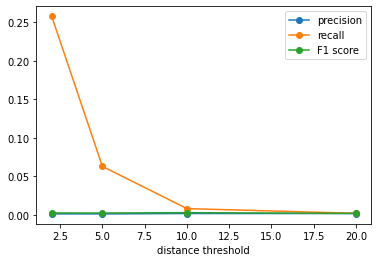

In [9]:
dists=[2,5,10,20]
precisions=[]
recalls=[]
F1s=[]
for dist_thre in dists:
    TN=sum((dist_normal<dist_thre)*1)
    FN=sum((dist_anomaly<dist_thre)*1)
    FP=sum((dist_normal>=dist_thre)*1)
    TP=sum((dist_anomaly>=dist_thre)*1)

    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1=2*(precision*recall)/(precision+recall)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(F1)
plt.figure()
plt.plot(dists,precisions,"-o")
plt.plot(dists,recalls,"-o")
plt.plot(dists,F1s,"-o")
plt.xlabel("distance threshold")
plt.legend(["precision","recall","F1 score"]);

Since I reduced the dataset to be two-dimensional, I can visualize them in a 2D scatter plot. As seen in the scatter plot, the anomaly data is exactly sitting on the normal data, so it is impossible to identify them with any distance measure in the reduced dataset. This too much reduction is exhibited in the low coverage of the data variances, ~27%.

PCA explained variance ratio: 0.2662588174713756


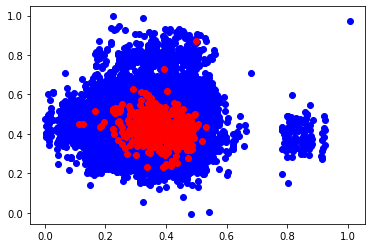

In [10]:
print("PCA explained variance ratio:",sum(pca.explained_variance_ratio_))

plt.figure
plt.scatter(df_proj_normal["dim1"],df_proj_normal["dim2"],color="b")
plt.scatter(df_proj_anomaly["dim1"],df_proj_anomaly["dim2"],color="r");